# Customer Analytics for a Telecom Provider

### Importing Libraries

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Load Dataset

In [3]:
df = pd.read_csv("dataset/telecom_customer_data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,CUST00001,Male,0,Yes,No,54,No,No phone service,Fiber optic,No internet service,Yes,No internet service,Yes,No internet service,No internet service,Two year,Yes,Mailed check,96.48,No
1,CUST00002,Female,0,No,No,35,Yes,No,No,Yes,No,Yes,Yes,No,No internet service,One year,No,Credit card (automatic),87.58,No
2,CUST00003,Male,0,Yes,No,36,Yes,No phone service,No,No internet service,No internet service,No internet service,Yes,Yes,Yes,Month-to-month,No,Bank transfer (automatic),79.78,No
3,CUST00004,Male,0,No,Yes,13,No,No phone service,Fiber optic,No,Yes,No,No,No internet service,No internet service,One year,Yes,Bank transfer (automatic),112.28,Yes
4,CUST00005,Male,1,No,Yes,26,Yes,No,Fiber optic,No,Yes,No,No,No internet service,No internet service,Month-to-month,Yes,Mailed check,45.77,Yes


### Info about data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5000 non-null   object 
 1   gender            5000 non-null   object 
 2   SeniorCitizen     5000 non-null   int64  
 3   Partner           5000 non-null   object 
 4   Dependents        5000 non-null   object 
 5   tenure            5000 non-null   int64  
 6   PhoneService      5000 non-null   object 
 7   MultipleLines     5000 non-null   object 
 8   InternetService   5000 non-null   object 
 9   OnlineSecurity    5000 non-null   object 
 10  OnlineBackup      5000 non-null   object 
 11  DeviceProtection  5000 non-null   object 
 12  TechSupport       5000 non-null   object 
 13  StreamingTV       5000 non-null   object 
 14  StreamingMovies   5000 non-null   object 
 15  Contract          5000 non-null   object 
 16  PaperlessBilling  5000 non-null   object 


### Descriptive Statistics of data

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5000.0,0.498200,0.500047,0.0,0.0000,0.000,1.000,1.0
tenure,5000.0,35.828400,20.994340,0.0,17.7500,36.000,54.000,72.0
MonthlyCharges,5000.0,70.229976,27.907778,18.0,49.4375,70.185,90.895,120.0


In [6]:
df.describe(include=['object']).T

,count,unique,top,freq
customerID,5000,5000,CUST05000,1
gender,5000,2,Male,2504
Partner,5000,2,Yes,2508
Dependents,5000,2,No,2501
PhoneService,5000,2,No,2542
MultipleLines,5000,3,No phone service,1712
InternetService,5000,3,DSL,1782
OnlineSecurity,5000,3,No internet service,1740
OnlineBackup,5000,3,No,1690
DeviceProtection,5000,3,No,1755


In [7]:
df['Churn'].value_counts()

Churn
No     3652
Yes    1348
Name: count, dtype: int64

so, here data is imbalanced

In [8]:
df1 = df.copy()

### Finding Duplicates

In [9]:
df1.duplicated().any()

np.False_

So, here are no duplicate entries.

### Dropping unnecessary column

In [10]:
df1.drop('customerID', axis=1, inplace=True)

### Finding Missing Values

In [11]:
# checking missing values before removing whitespaces
df1.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
dtype: int64

In [12]:
# Remove leading/trailing whitespaces from all object columns.
# This helps detect hidden missing values like '   ' or 'NaN ' (with spaces), which are strings and not recognized as actual NaN by pandas.
for column in df1.select_dtypes(include=['object']).columns:
    df1[column] = df1[column].str.strip()

In [13]:
# checking missing values after removing whitespaces
df1.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
dtype: int64

So, Here no missing values present.

### Finding Outliers

#### Separating numerical columns and categorical columns

In [14]:
numerical_cols = ['tenure','MonthlyCharges','SeniorCitizen']
categorical_cols = []
for col in df1.columns:
    if col not in numerical_cols:
        categorical_cols.append(col)
print(categorical_cols)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


#### Finding outliers using boxplot in numerical columns

In [15]:
fig = make_subplots(rows=1, cols=3, subplot_titles=numerical_cols)
for i, column in enumerate(numerical_cols):
    row = 1
    col = i + 1

    boxplot = px.box(df1, x=column)
    for trace in boxplot.data:
        fig.add_trace(trace, row=row, col=col)
fig.update_layout(height=500, width=1300, showlegend=False)

So, Here no outliers in numerical columns.

#### Value counts of Categorical columns to see imbalance data

using plotly

In [16]:
fig = make_subplots(rows=4, cols=4, subplot_titles=categorical_cols)
for i, column in enumerate(categorical_cols):
    row = i // 4 + 1
    col = i % 4 + 1

    value_counts = df1[column].value_counts().reset_index()
    value_counts.columns = ['Category', 'count']

    bar = go.Bar(
        x=value_counts['Category'],
        y=value_counts['count'],
        text=value_counts['count'],
        showlegend=True
    )
    fig.add_trace(bar, row=row, col=col)

fig.update_layout(height=1300, width=1200, title_text="Value Counts of Categorical Columns")
fig.show()


using seaborn

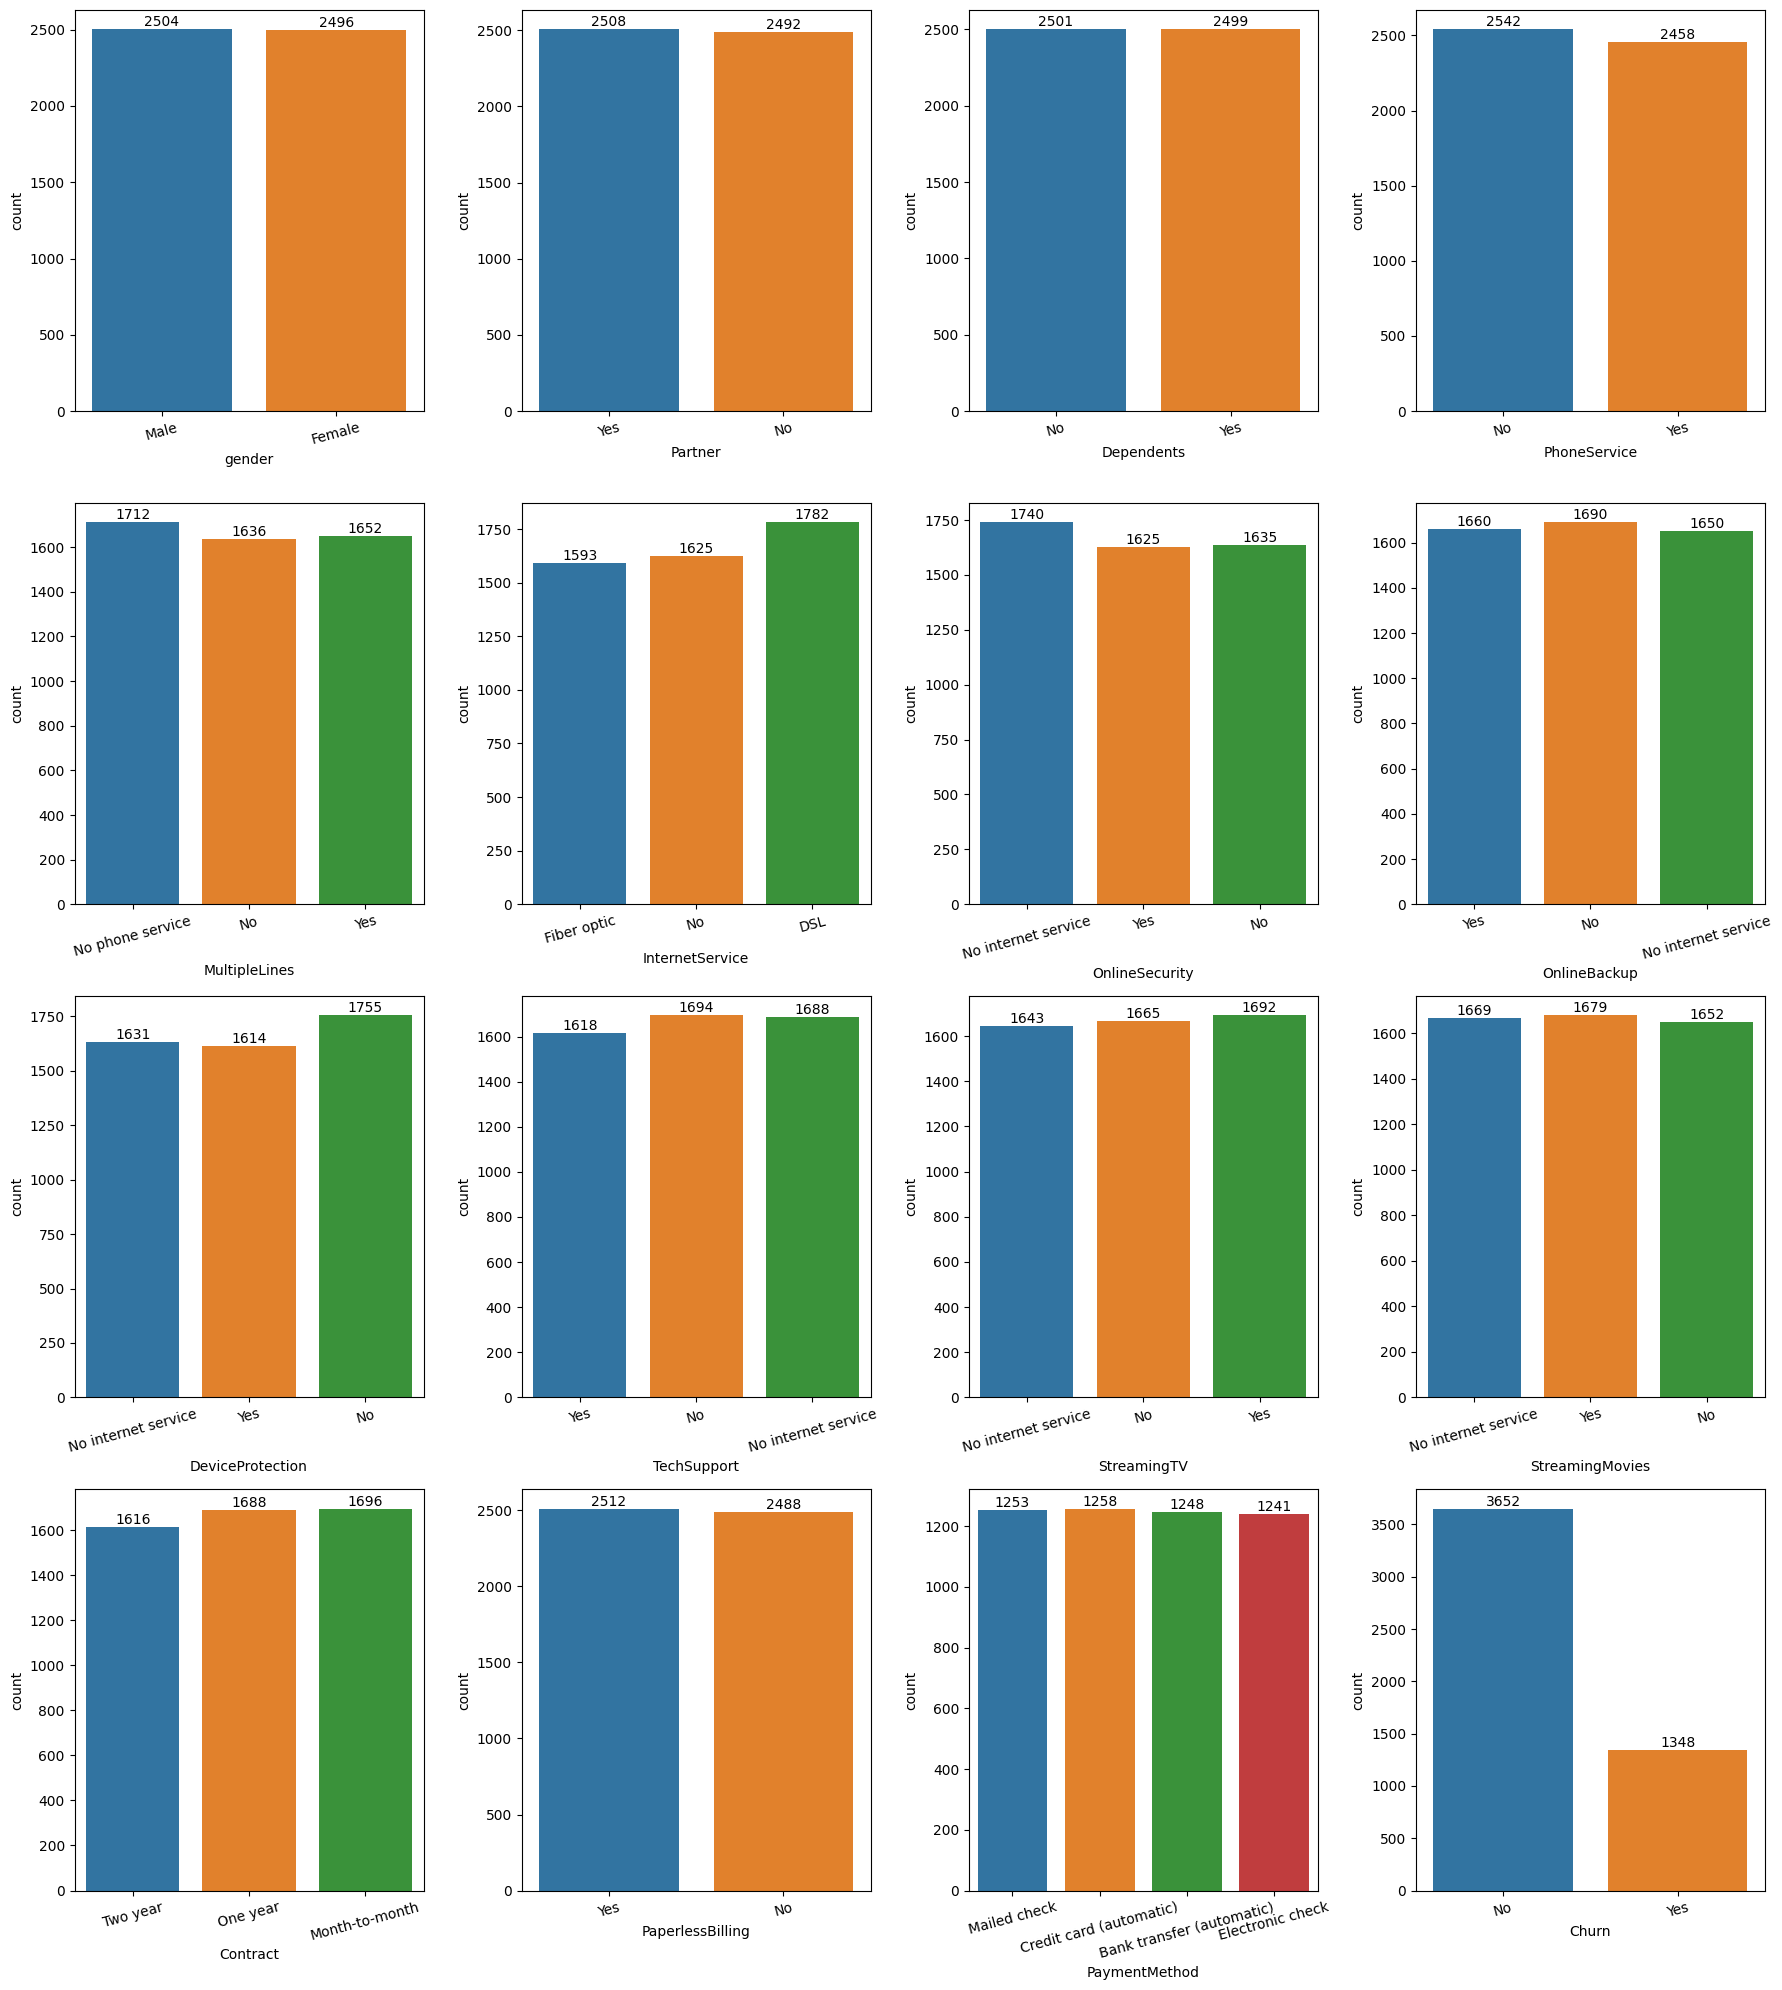

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18, 20))

for ax, column in zip(axes.flatten(), categorical_cols):
    sns_fig = sns.countplot(data=df1, ax=ax, x=column, hue=column)
    sns_fig.tick_params(axis='x', rotation=15)
    for container in sns_fig.containers:
        sns_fig.bar_label(container)

plt.tight_layout()
plt.show()

### EDA - Exploratory Data Analysis

In [18]:
import warnings
warnings.filterwarnings('ignore')

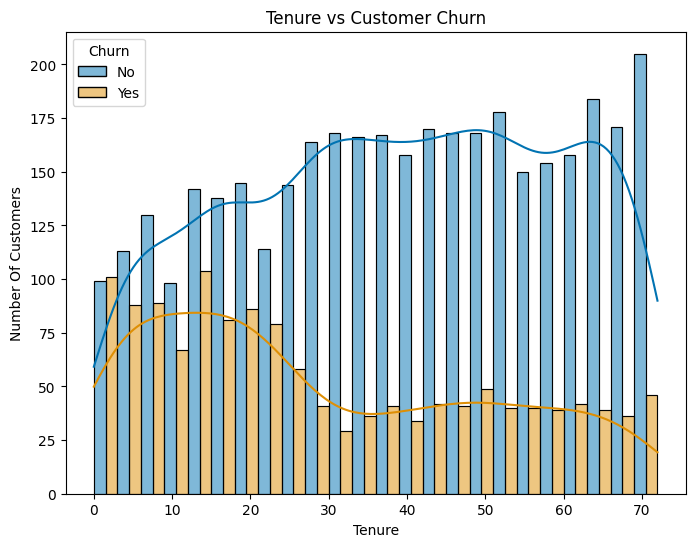

In [48]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df1, x='tenure', hue='Churn', multiple='dodge', bins=20, binwidth=3, palette='colorblind', kde=True)

plt.xlabel("Tenure")
plt.ylabel("Number Of Customers")
plt.title("Tenure vs Customer Churn")
plt.show()

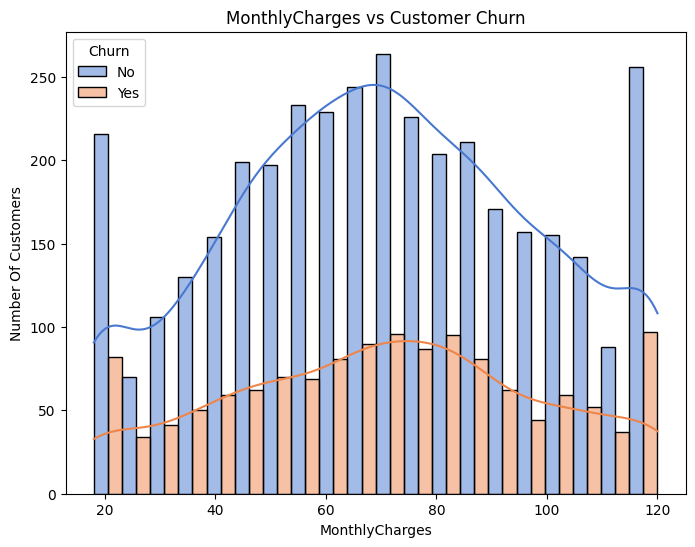

In [47]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df1, x='MonthlyCharges', hue='Churn', multiple='dodge', bins=20, palette='muted', kde=True)

plt.xlabel("MonthlyCharges")
plt.ylabel("Number Of Customers")
plt.title("MonthlyCharges vs Customer Churn")
plt.show()

In [56]:
for col in df1.columns:
    print(f'{col}: {df1[col].unique()}')

gender: ['Male' 'Female']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [54 35 36 13 26 30 72 43 67 47 56 21  3 71 45 58 33 10 55 37 20  9 25  7
 59 15 12 63  1 68 29 60 64 66 42 34 38 50  4 19 23 53 16 17 52 49 44 65
 46 18  5  6  2 24 14 61 39 51 31 62 48 22 32 69 27 70 40 11  0 28  8 41
 57]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['Fiber optic' 'No' 'DSL']
OnlineSecurity: ['No internet service' 'Yes' 'No']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No internet service' 'Yes' 'No']
TechSupport: ['Yes' 'No' 'No internet service']
StreamingTV: ['No internet service' 'No' 'Yes']
StreamingMovies: ['No internet service' 'Yes' 'No']
Contract: ['Two year' 'One year' 'Month-to-month']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Mailed check' 'Credit card (automatic)' 'Bank transfer (automatic)'
 'Electronic check']
MonthlyCharges: [96.48 87.58 79.78 ... 77.88 44.73 91.49]
Churn: ['